<a href="https://colab.research.google.com/github/tizianofucci/A2NDLVisualQuestionAnswering/blob/master/Notebook/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [117]:
import os

# os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tensorflow as tf
import numpy as np

# Set the seed for random operations. 
# This let our experiments to be reproducible. 
SEED = 1234
tf.random.set_seed(SEED)  

In [118]:
cwd = os.getcwd()

In [119]:
# Colab Pro
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Sat Jan  9 16:41:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |   1477MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [147]:
labels_dict  = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}


In [148]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [149]:
!unzip /content/drive/MyDrive/anndl-2020-vqa.zip

Archive:  /content/drive/MyDrive/anndl-2020-vqa.zip
replace VQA_Dataset/Images/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [150]:
ls

drive/  model.png  multiclass_exps/  sample_data/  VQA_Dataset/


# Example: Image Segmentation
## Build segmentation

In [176]:
import shutil
import random
import json
import math

SEED = 1234
tf.random.set_seed(SEED)  

# Get current working directory
cwd = "VQA_Dataset"

#Save all possible path in order to be able to cycle over them
dataset_image_dir = os.path.join(cwd,'Images')

dataset_QA = os.path.join(cwd,'train_questions_annotations.json')

test_QA = os.path.join(cwd,'test_questions.json')


In [ ]:
print(dataset_QA)
print(test_QA)

In [ ]:
with open(dataset_QA) as f:
    q_dict = json.load(f)

In [ ]:
for key in q_dict:
#     q_dict[key]['answer'] = labels_dict[q_dict[key]['answer']]
    print(q_dict[key]['answer'])

In [ ]:
# Prepare dataset
# ---------------




MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

answers = []
questions = []
eng_sentences_train = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in q_dict:


#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    answer = q_dict[key]['answer']
    question = q_dict[key]['question']

    
    if (len(answer.split(' ')) > MAX_LEN or
          len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    questions.append(question)
    
    answer_arr = np.zeros(58)
    answer_arr[labels_dict[q_dict[key]['answer']]] = 1
    
    q_dict[key]['answer'] = answer_arr
    answers.append(answer)
    
    count += 1

print('Number of questions:', len(questions))

In [ ]:
max(len(sentence.split(' ')) for sentence in questions)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Create Tokenizer to convert words to integers
ita_tokenizer = Tokenizer(num_words= MAX_NUM_WORDS)
ita_tokenizer.fit_on_texts(questions)
ita_tokenized = ita_tokenizer.texts_to_sequences(questions)

ita_wtoi = ita_tokenizer.word_index
print('Total Questions words:', len(ita_wtoi))

max_ita_length = max(len(sentence) for sentence in ita_tokenized)
print('Max question length:', max_ita_length)

In [ ]:
# Pad to max italian sentence length
ita_encoder_inputs = pad_sequences(ita_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", ita_encoder_inputs.shape)


In [ ]:
count = 0
for key in q_dict:
    q_dict[key]['question'] = ita_encoder_inputs[count]
    count+=1
 

In [ ]:
# Build Encoder-Decoder Model
# ---------------------------

EMBEDDING_SIZE = 32

# ENCODER
# -------

encoder_input = tf.keras.Input(shape=[max_ita_length])
encoder_embedding_layer = tf.keras.layers.Embedding(len(ita_wtoi)+1, EMBEDDING_SIZE, input_length=max_ita_length, mask_zero=True)
encoder_embedding_out = encoder_embedding_layer(encoder_input)
encoder = tf.keras.layers.LSTM(units=512, return_state=True)

encoder_output, h, c = encoder(encoder_embedding_out)
encoder_states = [h, c]



# MODEL
model_lstm = tf.keras.Model(encoder_input,encoder_output, name='model')

In [ ]:
model_lstm.summary()

In [ ]:
# ImageDataGenerator
# ------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = False

# Create training ImageDataGenerator object
# We need two different generators for images and corresponding masks
if apply_data_augmentation:
    img_data_gen = ImageDataGenerator(rotation_range=10,
                                      width_shift_range=10,
                                      height_shift_range=10,
                                      zoom_range=0.3,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='reflect')
else :
    img_data_gen = ImageDataGenerator()


In [ ]:
from PIL import Image

class CustomDataset(tf.keras.utils.Sequence):

    """
        CustomDataset inheriting from tf.keras.utils.Sequence.

        3 main methods:
          - __init__: save dataset params like directory, filenames..
          - __len__: return the total number of samples in the dataset
          - __getitem__: return a sample from the dataset

        Note: 
          - the custom dataset return a single sample from the dataset. Then, we use 
            a tf.data.Dataset object to group samples into batches.
          - in this case we have a different structure of the dataset in memory. 
            We have all the images in the same folder and the training and validation splits
            are defined in text files.

      """

    def __init__(self, dataset_dir, which_subset, img_generator=None, mask_generator=None, 
                preprocessing_function=None, out_shape=[256, 256]):
        if which_subset == 'training':
            subset_file = os.path.join(dataset_dir, 'Splits', 'train.txt')
        elif which_subset == 'validation':
            subset_file = os.path.join(dataset_dir, 'Splits', 'val.txt')
    
        with open(subset_file, 'r') as f:
            lines = f.readlines()
    
        subset_filenames = []
        for line in lines:
            subset_filenames.append(line.strip()) 

        self.which_subset = which_subset
        self.dataset_dir = dataset_dir
        self.subset_filenames = subset_filenames
        self.img_generator = img_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape

    def __len__(self):
        return len(self.subset_filenames)

    def __getitem__(self, index):
        
        
        
        
        # Read Image
        curr_filename = self.subset_filenames[index]
        element = q_dict[curr_filename]
        image = element['image_id']
        img = Image.open(os.path.join(self.dataset_dir, 'Images', image + '.png'))
        #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

        img = img.convert('RGB')
        
        # Resize image and mask
        img = img.resize(self.out_shape)
        

        
       # mask = mask.resize(self.out_shape)
    
        img_arr = np.array(img)
        
        
        
        question = element['question']
        answer = element['answer']
        #print(mask_arr.shape)
  
#         if self.which_subset == 'training':
#             if self.img_generator is not None and self.mask_generator is not None:
                # Perform data augmentation
                # We can get a random transformation from the ImageDataGenerator using get_random_transform
                # and we can apply it to the image using apply_transform
                
#                 img_t = self.img_generator.get_random_transform(img_arr.shape, seed=SEED)
#                 mask_t = self.mask_generator.get_random_transform(mask_arr.shape, seed=SEED)
#                 img_arr = self.img_generator.apply_transform(img_arr, img_t)
                
                # ImageDataGenerator use bilinear interpolation for augmenting the images.
                # Thus, when applied to the masks it will output 'interpolated classes', which
                # is an unwanted behaviour. As a trick, we can transform each class mask 
                # separately and then we can cast to integer values (as in the binary segmentation notebook).
                # Finally, we merge the augmented binary masks to obtain the final segmentation mask.
#                 out_mask = np.zeros_like(mask_arr)
#                 for c in np.unique(mask_arr):
#                     if c > 0:
#                         curr_class_arr = np.float32(mask_arr == c)
#                         curr_class_arr = self.mask_generator.apply_transform(curr_class_arr, mask_t)
#                         # from [0, 1] to {0, 1}
#                         curr_class_arr = np.uint8(curr_class_arr)
#                         # recover original class
#                         curr_class_arr = curr_class_arr * c 
#                         out_mask += curr_class_arr
#         else:
    
        if self.preprocessing_function is not None:
            img_arr = self.preprocessing_function(img_arr)
        
        pair = {"input_1": img_arr, "input_2": question}
        
        return pair, answer

In [ ]:
if not os.path.exists(os.path.join(cwd,"Splits/")):
    os.makedirs(os.path.join(cwd,"Splits/"))



import json



# Output: {'name': 'Bob', 'languages': ['English', 'Fench']}

val=[]
train=[]

for key in q_dict:
# image_filenames = next(os.walk(os.path.join(dataset_dir[j],"Images/")))[2]



# for image_name in image_filenames:
    if 100*random.random() < 10:
        val.append(key)
    else:
        train.append(key)

with open(os.path.join(cwd,"Splits","train.txt"), 'w') as file:  # Use file to refer to the file object
    for i in train:
        a = file.write(str(i)+"\n")

with open(os.path.join(cwd,"Splits","val.txt"), 'w') as file:  # Use file to refer to the file object
    for i in val:
        a = file.write(str(i)+"\n")



In [ ]:
#Creation of dataset generators (the commented line are the ones for getting also the haricot Dataset)

from tensorflow.keras.applications.vgg16 import preprocess_input 

img_h = 400
img_w = 700

dataset = CustomDataset(cwd, 'training', 
                        img_generator=img_data_gen, preprocessing_function=None, out_shape=[img_w,img_h])

dataset_valid = CustomDataset(cwd, 'validation',
                              preprocessing_function=None,out_shape=[img_w,img_h])



In [ ]:
#Creation of datasets (the commented line are the ones for getting also the haricot Dataset)


train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.float32),
                                               output_shapes=({"input_1": [img_h, img_w, 3], "input_2":  22}, 58)
                                              )

bs=64


train_dataset = train_dataset.batch(bs)

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=({"input_1": tf.float32, "input_2": tf.float32}, tf.float32),
                                               output_shapes=({"input_1": [img_h, img_w, 3], "input_2":  22}, 58)
                                              )

valid_dataset = valid_dataset.batch(bs)

valid_dataset = valid_dataset.repeat()

In [ ]:
# Let's test data generator
# -------------------------

import time
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline


# Assign a color to each class
evenly_spaced_interval = np.linspace(0, 1, 3)
colors = [cm.rainbow(x) for x in evenly_spaced_interval]

iterator = iter(valid_dataset)

[0 0 0 ... 78 446 1]
[0 0 0 ... 0 0 1]


<function matplotlib.pyplot.plot>

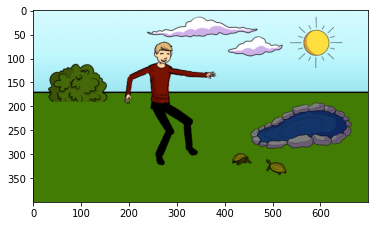

In [168]:
augmented_img = next(iterator)


image = augmented_img[0]['input_1'][0]   # First element

tf.print (augmented_img[0]['input_2'][0])
tf.print (augmented_img[1][0])

plt.imshow(np.uint8(image))
plt.plot

In [169]:
#Loading of VGG that will be used as a Backbone
vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))

# for layer in vgg.layers:
#   layer.trainable = False
freeze_until = 18 # layer from which we want to fine-tune

for layer in vgg.layers[:freeze_until]:
    layer.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 400, 700, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 700, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 700, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 350, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 350, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 350, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 175, 128)     0     

In [170]:
# This function is used for creating a model without skip connections
def create_model():

    model = tf.keras.Sequential()
    model2 = tf.keras.Sequential()
    # Encoder
    # -------
    model.add(vgg)
    model2.add(model_lstm)
    model.add(tf.keras.layers.GlobalAveragePooling2D())

    
    scores = tf.keras.layers.Multiply()([model.output, model2.output])
    
    denso = tf.keras.layers.Dense(units=256, activation='selu')(scores)

    output = tf.keras.layers.Dense(units=58, activation='softmax')(denso)
    
    final_model = tf.keras.Model([model.inputs,model2.inputs], output)


    return final_model

In [171]:
model = create_model()

In [172]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
vgg16_input (InputLayer)        [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 12, 21, 512)  14714688    vgg16_input[0][0]                
__________________________________________________________________________________________________
model_input (InputLayer)        [(None, 22)]         0                                            
__________________________________________________________________________________________________
global_average_pooling2d_6 (Glo (None, 512)          0           vgg16[0][0]                      
____________________________________________________________________________________________

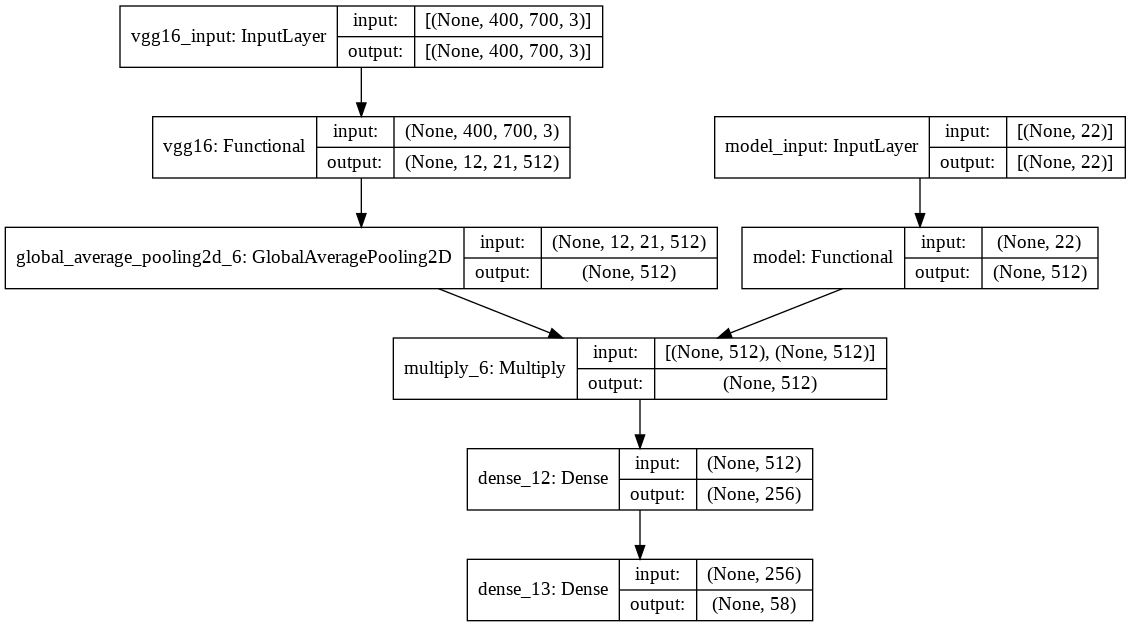

In [173]:
tf.keras.utils.plot_model(model, show_shapes=True)


In [174]:
# Optimization params
# -------------------

# Loss
# Sparse Categorical Crossentropy to use integers (mask) instead of one-hot encoded labels
loss = tf.keras.losses.CategoricalCrossentropy() 


# learning rate
lr = 5e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------


# Validation metrics
# ------------------
metrics = ['accuracy']
# ------------------



# Compile Model
model.compile(optimizer=optimizer, loss=loss , metrics=metrics)

In [175]:
import os
from datetime import datetime

cwd1 = os.getcwd()

exps_dir = os.path.join(cwd1, 'multiclass_exps')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=0)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
    callbacks.append(es_callback)


model.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=len(dataset)/bs,#+len(dataset1)
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid)/bs, #+len(dataset_valid1)
          callbacks=callbacks)

# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser

Epoch 1/100


ValueError: ignored

In [ ]:
#Function for creating the result in a csv file

from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
with open(dataset_QA) as f:
    test_dict = json.load(f)


MAX_NUM_SENTENCES = 70000
MAX_NUM_WORDS = 20000

test_questions = []

# Simplify the dataset
MAX_LEN = 25 # words

# Read all lines in translation dataset
count = 0

for key in test_dict:

#for line in open(os.path.join('/content/drive/My Drive', 'ita.txt'), encoding='utf-8'):
    
    if count > MAX_NUM_SENTENCES:
        break

        
    question = test_dict[key]['question']

    
    if (len(question.split(' ')) > MAX_LEN):
      continue
    
    question = question + ' <eos>'
       
    test_questions.append(question)
    
    count += 1

test_tokenized = ita_tokenizer.texts_to_sequences(test_questions)

# Pad to max italian sentence length
test_encoder_inputs = pad_sequences(test_tokenized, maxlen=max_ita_length)

print("Italian encoder inputs shape:", test_encoder_inputs.shape)

count = 0
for key in test_dict:
    test_dict[key]['question'] = test_encoder_inputs[count]
    count+=1
 

In [ ]:
#Prediction computation done one image at time

#model.load_weights(filepath='C:\\Users\\ASUS\\Documents\\Università\\ANNDL\\A2NDLKaggle\\weights\\FC_Nov14_15-02-54\\ckpts\\cp.ckpt')

from PIL import Image

results = {}
for key in test_dict:
    
    image = tf.keras.preprocessing.image.load_img(test_dir+image_name,target_size=(img_h,img_w))
    # Read Image
    element = test_dict[key]
    image = element['image_id']
    img = Image.open(os.path.join(self.dataset_dir, 'Images', image + '.png'))
    #mask = rme.read_rgb_mask(os.path.join(self.dataset_dir, 'Masks', curr_filename + '.png'))

    img = img.convert('RGB')
    
    # Resize image and mask
    img = img.resize((img_h,img_w))
    img_arr = np.array(img)
    question = element['question']

    pair = {"input_1": img_arr, "input_2": question}  
    
    predictions = model.predict_classes(pair)
    results[key] = predictions[0]

create_csv(results)
print (results)

In [ ]:
model.inputs

In [ ]:
model.save_weights(os.path.join(os.getcwd(),'multiclass_exps/Manual/ckpts/cp.ckpt'))


In [177]:
train_dataset

<RepeatDataset shapes: ({vgg16_input: (None, 400, 700, 3), model_input: (None, 22)}, (None, 58)), types: ({vgg16_input: tf.float32, model_input: tf.float32}, tf.float32)>